In [2]:
import os, glob
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
#from torchvision.transforms import ToTensor
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
#import tensorflow

In [3]:
num_roi = 128
num_tasks = 4

In [4]:
def get_tensor(sub_data):
    """
    this function take each subject's connectivity dataframe, and convert them to input and label
    returns: X = 1d-array connectivity input; y = 1d-array task label
    """
    #remove self correlations
    sub_data = sub_data.loc[sub_data.level_0 != sub_data.level_1]
    #get only lower triangle
    sub_data = sub_data.sort_values(by='correlation').iloc[::2, :]
    #sanity check
    assert(len(sub_data['correlation'])) == num_roi*(num_roi-1)/2*num_tasks
        
    #separate into input and label
    mydict = sub_data.sort_values(by=['task', 'level_0', 'level_1']).groupby('task')['correlation'].apply(list)
    labels = [i for i,v in enumerate(mydict.keys())]
    data = [i for i in mydict]
    #turn to tensor: input and label
    X = torch.from_numpy(np.hstack(data).reshape(4, -1))
    #y = torch.nn.functional.one_hot(torch.tensor(labels))
    y = torch.tensor(labels)
    return X, y

In [5]:
#load data
def load_data():
    """
    this function reads all subject connectivity data and returns all inputs and labels
    look at get tensor for specifics
    """
    all_inputs = torch.tensor([])
    all_labels = torch.tensor([])
    for i in os.listdir('processed_data'):
        try:
            sub_data = pd.read_csv('processed_data/' + i, index_col=[0])
            X, y = get_tensor(sub_data)
            all_inputs = torch.cat([all_inputs, X])
            all_labels = torch.cat([all_labels, y])    
        except:
            pass
        
    #make sure they are of the same size
    assert(torch.Tensor.size(all_inputs)[0] == torch.Tensor.size(all_labels)[0])
    return all_inputs, all_labels

In [6]:
all_inputs, all_labels = load_data()
len(all_inputs)

556

In [7]:
#load subdata

# sub = 'sub-10249'
# sub_data = pd.read_csv('processed_data/' + sub + '.csv', index_col=[0])
# #remove self correlations
# sub_data = sub_data.loc[sub_data.level_0 != sub_data.level_1]
# #get only lower triangle
# sub_data = sub_data.sort_values(by='correlation').iloc[::2, :]
# sub_data.head()

In [65]:
# Define model
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(int(num_roi*(num_roi-1)/2), 4096),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, 1024),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(512, 32),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(32, num_tasks),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
#print(model)

In [52]:
len(all_inputs)

556

In [61]:
batch_size = 80
batch_num = int(np.ceil(len(all_inputs)/batch_size))
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
all_inputs = all_inputs.to(torch.float32)
all_labels = all_labels.type(torch.LongTensor)
dataset = TensorDataset(all_inputs, all_labels)
num_epochs = 100
lr = 0.65

In [11]:
# for fold, (train_indices, val_indices) in enumerate(kfold.split(all_inputs, all_labels)):
#     print(f"Fold {fold + 1}/{num_folds}")
    
#     # Create data loaders for training and validation sets
#     train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
#     train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    
#     val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
#     val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
#     # Initialize the neural network
#     model = NeuralNetwork()
    
#     # Define loss function and optimizer
#     loss_fn = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
        
#         for inputs, labels in train_loader:
#             # Initialize optimizer
#             optimizer.zero_grad()
#             # Compute prediction and loss:
#             outputs = model(inputs)
#             loss = loss_fn(outputs, labels)
#             # Backpropagation
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
            
#         print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss}")
        
#         # Validation loop
#         model.eval()
#         correct = 0
#         total = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         accuracy = correct / total
#         print(f"Validation Accuracy: {accuracy}")
#         print("-" * 40)

In [88]:
#cross validation
for fold, (train_indices, test_indices) in enumerate(kfold.split(all_inputs, all_labels)):
    #get data
    train_X = all_inputs[train_indices]
    train_y = all_labels[train_indices]
    test_X = all_inputs[test_indices]
    test_y = all_labels[test_indices]
    
    #Initialize the neural network
    model = NeuralNetwork()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.07, weight_decay=1e-5) #l2 regularization
    #train
    model, pred, all_loss = train(model, train_X, train_y)
    #test
    acc, pred = test(model, test_X, test_y)

loss: 1.386778  [    9/100]
train accuracy: 0.25
loss: 1.385445  [   19/100]
train accuracy: 0.25
loss: 1.383895  [   29/100]
train accuracy: 0.25
loss: 1.382027  [   39/100]
train accuracy: 0.25
loss: 1.379220  [   49/100]
train accuracy: 0.25
loss: 1.375264  [   59/100]
train accuracy: 0.3
loss: 1.368630  [   69/100]
train accuracy: 0.65
loss: 1.352562  [   79/100]
train accuracy: 0.8
loss: 1.277353  [   89/100]
train accuracy: 0.5
loss: 1.172299  [   99/100]
train accuracy: 0.8
Validation Accuracy: 0.35714285714285715
loss: 1.385360  [    9/100]
train accuracy: 0.4
loss: 1.383992  [   19/100]
train accuracy: 0.5
loss: 1.382365  [   29/100]
train accuracy: 0.5
loss: 1.380245  [   39/100]
train accuracy: 0.65
loss: 1.377347  [   49/100]
train accuracy: 0.95
loss: 1.372985  [   59/100]
train accuracy: 1.0
loss: 1.364974  [   69/100]
train accuracy: 0.9
loss: 1.343277  [   79/100]
train accuracy: 0.7
loss: 1.242310  [   89/100]
train accuracy: 0.75
loss: 1.180040  [   99/100]
train accu

In [49]:
#size = len(train_dataloader.dataset)
def train(model,
          all_inputs, 
          all_labels, 
          batch_num = batch_num,
          batch_size = batch_size,
          num_epochs=num_epochs):
    
    all_loss = [] #record loss
    for epoch in range(num_epochs):
        #shuffle
        #all_inputs, all_labels = shuffle(all_inputs, all_labels, random_state = epoch)

        # Walk through each training batch:
        for i in range(batch_num):
            #get batch X and y
            batch_X = all_inputs[i*batch_size: min((i+1)*batch_size, len(all_inputs))]
            batch_y = all_labels[i*batch_size: min((i+1)*batch_size, len(all_labels))]

            # Compute prediction and loss:
            pred = model(batch_X)
            loss = loss_fn(pred, batch_y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print out a status message every so often.
        if (1+epoch)%10==0:
            #get loss and accuracy
            (loss, current) = (loss.item(), epoch)
            all_loss.append(loss)
            accuracy = (torch.Tensor.argmax(pred, axis=1)==batch_y).sum().item() / len(pred)

            print(f"loss: {loss:>7f}  [{current:>5d}/{num_epochs}]")
            print(f"train accuracy: {accuracy}")
    return model, pred, all_loss

In [39]:
def test(model, 
        all_inputs,
        all_labels):
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        outputs = model(all_inputs)
        pred = torch.Tensor.argmax(outputs, axis=1)
        total += len(all_labels)
        correct += (pred == all_labels).sum().item()
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy}")
    
    return accuracy, pred

In [63]:
train_X = all_inputs[0:500,:]
train_y = all_labels[0:500]

test_X = all_inputs[500:, :]
test_y = all_labels[500:]

In [84]:
#initialize
model = NeuralNetwork()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.07)

In [85]:
num_epochs = 100
model, pred, all_loss = train(model, train_X, train_y, num_epochs=num_epochs)

loss: 1.385948  [    9/100]
train accuracy: 0.25
loss: 1.385207  [   19/100]
train accuracy: 0.25
loss: 1.384462  [   29/100]
train accuracy: 0.25
loss: 1.383692  [   39/100]
train accuracy: 0.25
loss: 1.382839  [   49/100]
train accuracy: 0.35
loss: 1.381814  [   59/100]
train accuracy: 0.45
loss: 1.380494  [   69/100]
train accuracy: 0.5
loss: 1.378784  [   79/100]
train accuracy: 0.55
loss: 1.376482  [   89/100]
train accuracy: 0.75
loss: 1.372759  [   99/100]
train accuracy: 0.75


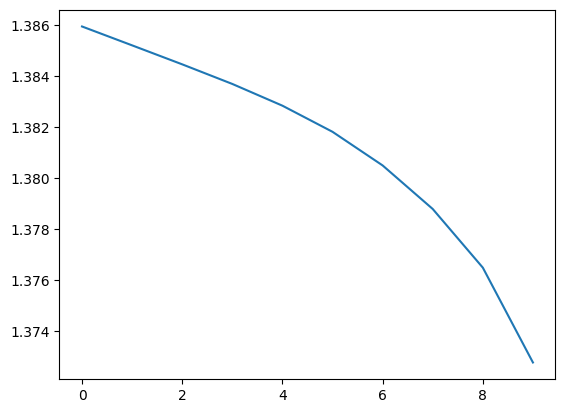

In [86]:
plt.plot(all_loss)

In [87]:
acc, pred = test(model, test_X, test_y)
pred

Validation Accuracy: 0.3392857142857143


tensor([2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 2, 2])

tensor([2, 2, 3, 2, 0, 2, 0, 1, 0, 1, 2, 3, 1, 0, 1, 0, 1, 0, 2, 1, 2, 3, 2, 0,
        1, 3, 1, 1, 1, 3, 1, 2, 0, 2, 2, 2, 2, 2, 3, 0, 3, 1, 1, 3, 1, 3, 1, 2,
        0, 3, 0, 1, 1, 3, 1, 0, 0, 3, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 3, 0,
        0, 2, 2, 3, 3, 0, 1, 2, 3, 0, 1, 0, 3, 0, 3, 0, 3, 0, 2, 3, 0, 1, 2, 3,
        3, 0, 3, 2, 1, 0, 2, 1, 0, 2, 0, 2, 3, 3, 3])

In [43]:
batch_y

tensor([2, 2, 3, 2, 0, 2, 0, 1, 0, 1, 2, 3, 1, 0, 1, 0, 1, 0, 2, 1, 2, 3, 0, 0,
        1, 3, 2, 1, 1, 3, 1, 2, 0, 2, 2, 2, 2, 2, 3, 0, 3, 1, 1, 0, 1, 3, 1, 2,
        0, 3, 0, 1, 1, 3, 1, 0, 0, 3, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 3, 0,
        0, 2, 2, 3, 3, 0, 1, 2, 3, 0, 1, 0, 3, 0, 3, 0, 3, 0, 2, 3, 0, 1, 2, 3,
        3, 0, 3, 2, 1, 0, 2, 1, 0, 2, 0, 2, 3, 3, 3])

In [44]:
pred

tensor([[5.6495e-05, 8.9299e-04, 9.9905e-01, 8.5277e-08],
        [1.8250e-04, 8.1147e-04, 9.9901e-01, 2.6857e-07],
        [1.5620e-08, 1.9710e-22, 1.1894e-17, 1.0000e+00],
        [1.3034e-04, 7.3710e-04, 9.9913e-01, 1.6838e-07],
        [9.9817e-01, 1.3569e-07, 1.3035e-03, 5.2380e-04],
        [9.5385e-05, 7.7177e-04, 9.9913e-01, 1.2550e-07],
        [9.9858e-01, 3.7874e-08, 4.7156e-04, 9.5324e-04],
        [1.6951e-21, 9.9884e-01, 1.1646e-03, 8.3888e-21],
        [9.9785e-01, 1.7551e-07, 1.6934e-03, 4.5244e-04],
        [3.7453e-35, 1.0000e+00, 4.5865e-07, 1.4012e-33],
        [1.5833e-05, 1.2461e-03, 9.9874e-01, 3.1998e-08],
        [2.6254e-09, 2.2762e-24, 2.9539e-19, 1.0000e+00],
        [4.2957e-24, 9.9977e-01, 2.2569e-04, 3.0484e-23],
        [9.9829e-01, 1.1212e-07, 1.0418e-03, 6.7296e-04],
        [5.7954e-22, 9.9904e-01, 9.5514e-04, 3.1111e-21],
        [9.9719e-01, 2.5562e-07, 2.3928e-03, 4.1524e-04],
        [2.9394e-24, 9.9975e-01, 2.5473e-04, 2.1946e-23],
        [9.975